In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import os
import keras
# tensorflow 용 시간체크와 tqdm
!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [2]:
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="webp", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Openai gym 부터 시작

In [ ]:
import gym
gym.envs.registry.all()

#### Cart-Pole

In [4]:
# catpole 설치
env = gym.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
# 환경 초기화
obs = env.reset()
obs

array([ 0.00064029, -0.00688407, -0.016608  , -0.02632992], dtype=float32)

In [ ]:
!pip install -U pyvirtualdisplay
# 파이썬 화면 가상환경
import pyvirtualdisplay

In [ ]:
env.render()

In [ ]:
# 환경 이미지를 np 배열로 로드
img = env.render(mode="rgb_array")
img.shape

In [9]:
# 이미지 변환 함수 정의
def plot_environment(env, figsize = (5,4)):
  plt.figure(figsize=figsize)
  img = env.render(mode="rgb_array")
  plt.imshow(img)
  plt.axis("off")
  return img

<function matplotlib.pyplot.show(close=None, block=None)>

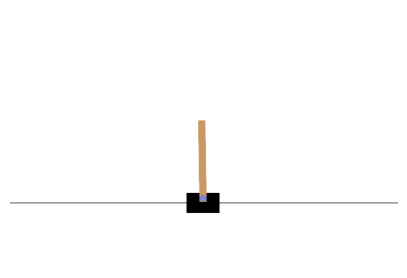

In [ ]:
# 카트 이미지 표시
plot_environment(env)
plt.show

In [ ]:
# 행동할 수 있는 종류
env.action_space

Discrete(2)

In [ ]:
# 카트 오른쪽으로 가속
action = 1
obs, reward, done, info = env.step(action)
obs

array([-0.01352815,  0.20459695, -0.01055758, -0.2837024 ], dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

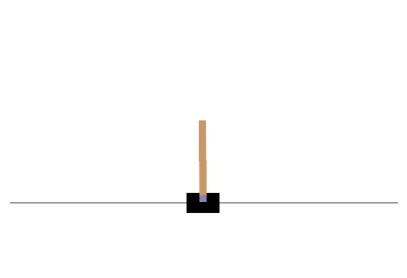

In [ ]:
# 카트 이미지 표시
plot_environment(env)
plt.show

In [ ]:
# 리워드 표시
reward

1.0

In [ ]:
done, info

(False, {})

In [ ]:
# 1 step 시퀸스 = episode
# 에피소드 끝에서 계속하기 전에 환경은 reset
if done:
  obs = env.reset()

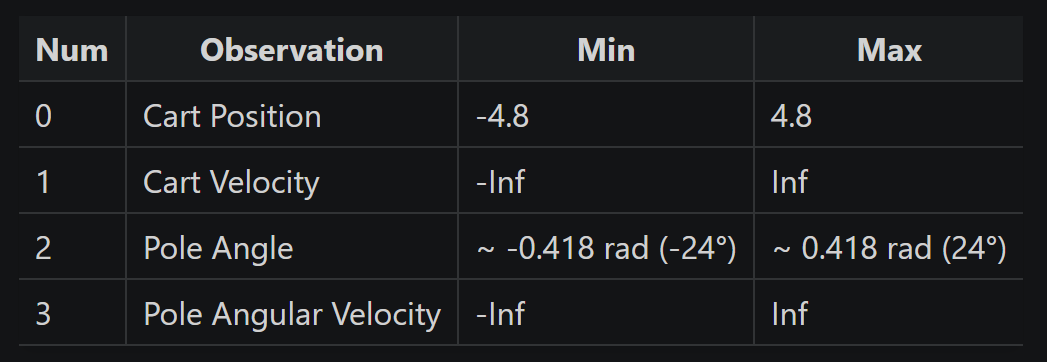

#### 간단한 정책

In [10]:
# 간단한 정책
# 막대가 왼쪽으로 가면 오른쪽으로 카트 이동
# 막대가 오른쪽으로 가면 왼쪽으로 카트 이동
def basic_policy(obs):
  angle = obs[2]
  return 0 if angle <0 else 1
totals = []

In [11]:
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()
  for step in range(200):
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [ ]:
totals[:5]

[47.0, 38.0, 39.0, 49.0, 40.0]

In [12]:
# 시각화
frames=[]
obs = env.reset()
for step in range(200):
  img = env.render(mode="rgb_array")
  frames.append(img)
  action = basic_policy(obs)

  obs, reward, done, info = env.step(action)
  if done:
    break
# 출력
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch,

def plot_animation(frames, repeat = False, interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames = len(frames), repeat=repeat, interval = interval
  )
  plt.close()
  return anim
# plot_animation(frames)

#### network policy

In [ ]:
# 초기화
keras.backend.clear_session()
# 신경망 모델 정의
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [23]:
# 모델 실행 > 에피소드 플레이 > 애니메이션 반환 함수 정의
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 67ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initi

1/1 [==============================] - 0s 17ms/step


In [ ]:
# 사용자 정의 훈련
n_environments = 50
n_iterations = 5000
envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

In [ ]:
# 5000회 반복 훈련을 통해 에피소드 진행 후 위치 업데이트
# 그라디언트 자동미분 이용
for iteration in range(n_iterations):
    target_probas = np.array([([1.] if obs[2] < 0 else [0])
    for obs in observations])
    with tf.GradientTape() as tape:
      left_probas = model(np.array(observations))
      loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\r Iteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)

    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
      obs, reward, done, info = env.step(actions[env_index][0])
      observations[env_index] = obs if not done else env.reset()
for env in envs:
  env.close()

 Iteration: 4999, Loss: 0.642

In [ ]:
# 이미지 애니메이션
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 16ms/step


#### Policy gradient

In [13]:
# 초기 하나의 스텝 정의
# 행동이 0이면 타겟은 왼쪽으로 이동, 행동이 1이면 오른쪽으로 이동(확률)
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [14]:
# 에피소드를 계속 반복하여 보상과 그레디언트 저장
# 모든 리워드와 그레디언트 업데이트
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [15]:
# 할인된 리워드 저장
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted
# 에피소드를 지속하면서 할인된 리워드 normalize
# 그 행동이 좋은 것인지 나쁜 것인지 지
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [16]:
# 할인된 리워드와 할인 비율 정의
# discounted_rewords([10, 0, -50], discount_rate=0.8)
discount_rewards([10, 0, -50], discount_rate=0.7)

array([-14, -35, -50])

In [17]:
# 전체 할인된 리워드의 평균, 표준편차 계산
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.7)

[array([-0.10239445, -0.81915557, -1.3311278 ]),
 array([1.19460187, 1.05807594])]

In [18]:
# 인수 정의
n_iterations = 60
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [19]:
# 최적화, 손실 정의
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
loss_fn = keras.losses.binary_crossentropy

In [20]:
# 모델 2층
keras.backend.clear_session()
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [21]:
# 학습 시작, 60회로 축소
# 각 반복당 10개 에피소드 반복
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
env.close()

Iteration: 59, mean rewards: 85.9

In [24]:
# 이미지 애니메이션
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 103ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


1/1 [==============================] - 0s 20ms/step


### 마르코프 결정 과정
> 1. Markov Chain

In [25]:
# 전이할 확률 정의
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],
        [0.0, 0.0, 0.9, 0.1],
        [0.0, 1.0, 0.0, 0.0],
        [0.0,
         0.0, 0.0, 1.0]]
n_max_steps = 50


In [26]:
# 시퀸스 반환
def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 0 0 0 0 0 0 0 0 0 3 
States: 0 0 0 0 3 
States: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


In [28]:
# Markov decision process
transition_probabilities = [
        [
            [0.7, 0.3, 0.0],
            [1.0, 0.0, 0.0],
            [0.8, 0.2, 0.0]
        ],
        [
            [0.0, 1.0, 0.0],
            None,
            [0.0, 0.0, 1.0]
        ],
        [
            None,
            [0.8, 0.1, 0.1],
            None
        ]
      ]
rewards = [
        [
            [+10, 0, 0],
            [0, 0, 0],
            [0, 0, 0]
        ],
        [
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, -50]
        ],
        [
            [0, 0, 0],
            [+40, 0, 0],
            [0, 0, 0]
        ]
      ]
possible_actions = [
    [0, 1, 2], [0, 2], [1]
    ]


#### Q-value algorithm 반복

In [32]:
# q가치 정의
# 가능한 행동할 시 (+)infinite vs 불가능한 행동할 시 (-)infinite
Q_values = np.full((3,3), -np.inf)
for state, actions in enumerate(possible_actions):
  Q_values[state, actions] = 0

In [34]:
# discount 계수
gamma = 0.9
history1 = []
# 50회 반복하는 q벨류 알고리즘
# 가능한 확률x리워드 + 감마x상태 s에 도달했을 때 가장 높은 q벨류
for iteration in range(50):
  Q_prev = Q_values.copy()
  history1.append(Q_prev)
  for s in range(3):
    for a in possible_actions[s]:
      Q_values[s, a] = np.sum([
          transition_probabilities[s][a][sp]*(rewards[s][a][sp]
          + gamma*np.max(Q_prev[sp]))
          for sp in range(3)
      ])
history1 = np.array(history1)

In [37]:
history1[:2]

array([[[  0.,   0.,   0.],
        [  0., -inf,   0.],
        [-inf,   0., -inf]],

       [[  7.,   0.,   0.],
        [  0., -inf, -50.],
        [-inf,  32., -inf]]])

In [38]:
# q값
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [39]:
# 각 상태 s마다 최적 행동 a가 갖는 값
np.argmax(Q_values, axis=1)

array([0, 0, 1])

In [40]:
# 실험 discount 계수 0.95
Q_values = np.full((3,3), -np.inf)
for state, actions in enumerate(possible_actions):
  Q_values[state, actions] = 0
gamma = 0.95
history1 = []
# 50회 반복하는 q벨류 알고리즘
# 가능한 확률x리워드 + 감마x상태 s에 도달했을 때 가장 높은 q벨류
for iteration in range(50):
  Q_prev = Q_values.copy()
  history1.append(Q_prev)
  for s in range(3):
    for a in possible_actions[s]:
      Q_values[s, a] = np.sum([
          transition_probabilities[s][a][sp]*(rewards[s][a][sp]
          + gamma*np.max(Q_prev[sp]))
          for sp in range(3)
      ])
history1 = np.array(history1)
# 상태 s에서 최적의 a
np.argmax(Q_values, axis=1)

array([0, 2, 1])

In [41]:
# q값
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

### Q-Learning
= 바둑에서의 게임 플레이. 초기값이나 위치도 전혀 알지 못함

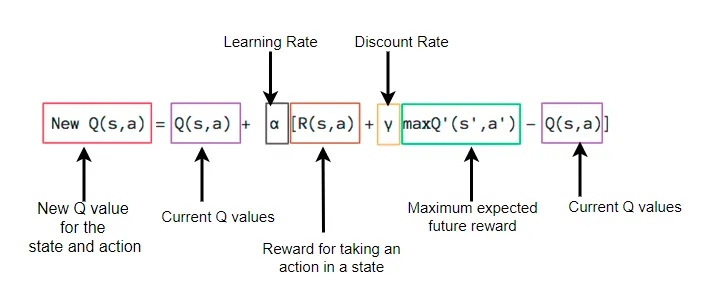

In [103]:
# 확률상 이동하는 함수 정의
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [104]:
# 탐험 policy정의
np.random.seed(4)
# 무작위성
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [105]:
# q벨류 초기화
Q_values = np.full((3,3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0
# 알고리즘 계수 정의
alpha0, decay, gamma, state, history2 = 0.05, 0.005, 0.9, 0, []


In [106]:
# iteration 10000회
# 최초 상태값 초기화/ 그리디 policy로 수행
for iteration in range(8000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    # 알파값 계속 변화
    Q_values[state, action] *= 1- alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state
# q러닝 시작
history2 = np.array(history2)

In [107]:
history2[-2:-1] # q벨류

array([[[ 17.6715303 ,  15.44792784,  12.48840158],
        [  0.        ,         -inf, -10.44682079],
        [        -inf,  48.1492636 ,         -inf]]])

In [108]:
Q_values

array([[ 17.64997439,  15.44792784,  12.48840158],
       [  0.        ,         -inf, -10.44220906],
       [        -inf,  48.1492636 ,         -inf]])

In [109]:
# 각 state s 에 대한 최적의 action a
np.argmax(Q_values, axis = 1)

array([0, 0, 1])

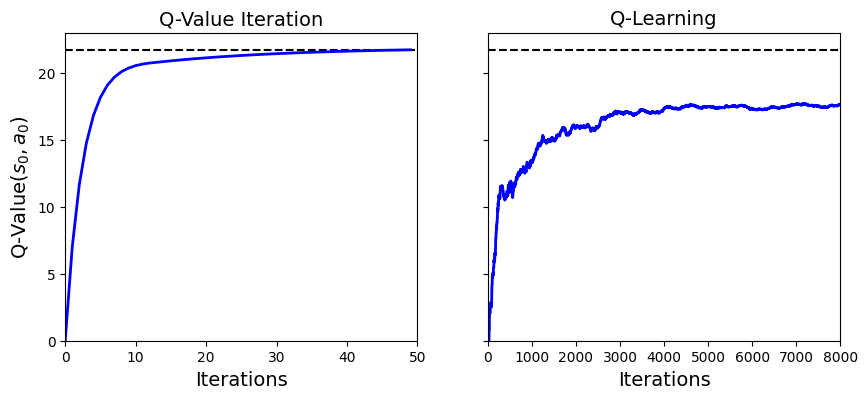

In [110]:
# 반복 횟수에 따른 Q-value 시각화
true_Q_value = history1[-1,0,0]
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 8000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 23])